In [27]:
%pip install scipy scikit-learn tensorflow keras-tuner

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [28]:
import sys
sys.path.append('../scripts')
from glucose import get_sensor_glucose_data
from load_csv import load_csv
from sklearn import preprocessing
import pandas as pd



# Blood glucos vs ISIG
The insulin pump obtains from the sensor inserted on skin a list of values (Volts), the amount of volts will vary depending on the instersticial glucose level of the patient (ISIG). 
The insulin pump requires the measurement of blood glucose level (on blood) to match with the ISIG alues obtained from the sensor. That procedure is called calibration.
The next code will show the correspondence of a blood glucose level with the ISIG values obtained from the sensor.

In [29]:
FILE_PATH = "../data/raw/24-08-04.csv"
data_frame = load_csv(FILE_PATH)

glucose = get_sensor_glucose_data(data_frame)
#remove all rows where "Sensor Glucose (mg/dL)" is greater or equal to 400
glucose = glucose[glucose["Sensor Glucose (mg/dL)"] < 400]
#remove all rows where "Sensor Glucose (mg/dL)" is less than or equals to 40
glucose = glucose[glucose["Sensor Glucose (mg/dL)"] > 40]

#get a sample of 10 rows of the dataframe
pd.set_option('display.max_rows', None)

print(glucose.sample(n=10, random_state=1))


             Date      Time  Sensor Glucose (mg/dL)  ISIG Value
30749  2024/03/04  08:10:43                     131       28.06
30257  2024/03/06  00:50:48                     168       35.10
12122  2024/05/08  14:51:25                     340       61.51
18460  2024/04/16  08:21:29                      95       19.95
19130  2024/04/14  00:31:22                     290       56.02
16685  2024/04/22  14:41:02                      66       17.24
14994  2024/04/28  14:16:24                     141       21.35
27894  2024/03/14  06:38:22                     123       20.86
20927  2024/04/07  17:57:52                     145       23.62
28626  2024/03/11  17:58:15                      76       17.67


Reviewing the Plot, we can conclude that to higher blood glucose, the major dispersion on ISIG values

[]

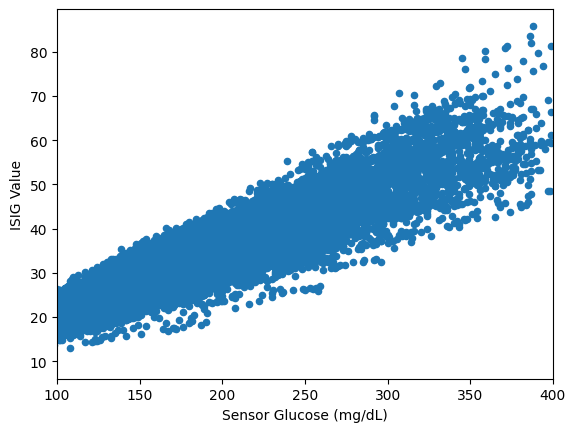

In [30]:

chart = glucose.plot.scatter(x="Sensor Glucose (mg/dL)", y="ISIG Value")
chart.set_xlim(100, 400)
chart.plot()


Checking patient's media of the blood glucose value

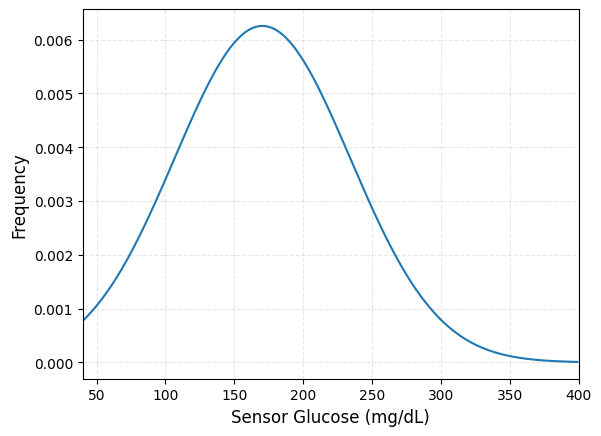

In [31]:
#get the gauss distribution of the glucose data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

df = glucose[["Sensor Glucose (mg/dL)"]]
# Calculating mean and Stdev of AGW
df_mean = np.mean(df["Sensor Glucose (mg/dL)"])
df_std = np.std(df["Sensor Glucose (mg/dL)"])
 
# Calculating probability density function (PDF)
pdf = stats.norm.pdf(df["Sensor Glucose (mg/dL)"].sort_values(), df_mean, df_std)

# Drawing a graph
plt.plot(df["Sensor Glucose (mg/dL)"].sort_values(), pdf)
plt.xlim([40,400])  
plt.xlabel("Sensor Glucose (mg/dL)", size=12)    
plt.ylabel("Frequency", size=12)                
plt.grid(True, alpha=0.3, linestyle="--")
plt.show()

## Normalizing Glucose and ISIG values
In order to use the data to train a machine learning the data collected from insulin pump must be normalized.
We will be comparing the results using a Min-Max Scaler and a standard scaler.

In [32]:
gs_minmax_scaler = preprocessing.MinMaxScaler()
isig_minmax_scaler = preprocessing.MinMaxScaler()
standard = preprocessing.StandardScaler()
glucose["gs_minmax"] = gs_minmax_scaler.fit_transform(glucose[["Sensor Glucose (mg/dL)"]])
glucose["isig_minmax"] = isig_minmax_scaler.fit_transform(glucose[["ISIG Value"]])
glucose["gs_standard"] = standard.fit_transform(glucose[["Sensor Glucose (mg/dL)"]])
glucose["isig_standard"] = standard.fit_transform(glucose[["ISIG Value"]])


## Trying to train the module
With normalized data, we're going to try training the model using the 2 selected type of normalization (minmax vs standard) to see if we could get better results with the different approaches

In [33]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
from keras import callbacks



def build_model(hp):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(1,)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    hp_learning_rate = hp.Choice('learning_rate', values=[0.1, 1e-2, 1e-3, 1e-4, 1e-5])  # Define as hp.Choice()


    model.compile( 
        optimizer=Adam(learning_rate=hp_learning_rate),
        loss='mean_squared_error',
        metrics=['mean_absolute_error'],
    )
    
    return model

minmax = glucose[['gs_minmax', 'isig_minmax']]
#evaluating the model with test data
X_train, X_val, y_train, y_val = train_test_split(minmax['isig_minmax'], minmax['gs_minmax'], test_size=0.2, random_state=42)
hp = kt.HyperParameters()
tuner = kt.GridSearch(
    build_model,
    objective='val_mean_absolute_error',
    hyperparameters=hp,
    directory='training',
    project_name='glucose_prediction'
)
tuner.search_space_summary()

earlystopping = callbacks.EarlyStopping(monitor="val_loss",
                                        mode="min",
                                        patience=10,
                                        restore_best_weights=True)
tuner.search(
    X_train.values.reshape(-1, 1), 
    y_train.values.reshape(-1, 1),
    epochs= 100,
    validation_data=(X_val, y_val),
    callbacks=[earlystopping]
)

# Get the best model and its hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters()[0].values
print("Best Hyperparameters:", best_hyperparameters)

#evaluating the model with test data
X_train, X_test, y_train, y_test = train_test_split(minmax['isig_minmax'], minmax['gs_minmax'], test_size=0.2, random_state=42)


minmax_hist = best_model.fit(X_train.values.reshape(-1, ), y_train.values.reshape(-1, ), epochs=100, validation_data=(X_test, y_test), callbacks=[earlystopping])
print(X_train.values.reshape(-1, ))

Trial 5 Complete [00h 11m 56s]
val_mean_absolute_error: 0.047697167843580246

Best val_mean_absolute_error So Far: 0.04755415767431259
Total elapsed time: 00h 21m 05s


/home/alejandro/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Best Hyperparameters: {'learning_rate': 0.0001}
Epoch 1/100


/home/alejandro/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


689/689 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0040 - mean_absolute_error: 0.0477 - val_loss: 0.0039 - val_mean_absolute_error: 0.0481
Epoch 2/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0040 - mean_absolute_error: 0.0484 - val_loss: 0.0040 - val_mean_absolute_error: 0.0476
Epoch 3/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0039 - mean_absolute_error: 0.0475 - val_loss: 0.0039 - val_mean_absolute_error: 0.0482
Epoch 4/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0039 - mean_absolute_error: 0.0478 - val_loss: 0.0039 - val_mean_absolute_error: 0.0475
Epoch 5/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0039 - mean_absolute_error: 0.0478 - val_loss: 0.0039 - val_mean_absolute_error: 0.0477
Epoch 6/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0039 - mean_absolute_error: 0.0477 - val_loss: 0.0039 - val_mean_absolute_error: 0.0482
Epoch 7/100
689/689 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0039 - mean_absolute_error: 0.0478 - val_lo

Test data size 22026 rows


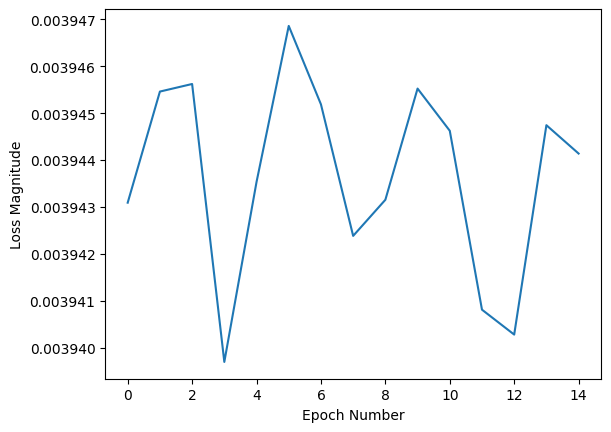

In [34]:
print("Test data size {} rows".format(len(X_train)))
plt.xlabel("Epoch Number")
plt.ylabel("Loss Magnitude")
plt.plot(minmax_hist.history["loss"])
plt.show()

## Perdicting values
Below we have a table of actual values to predict


In [35]:
print("PREDICTING VALUES!!")
"""
18941  2024/04/14  16:16:25                     345       60.00
17159  2024/04/20  23:10:57                     345       60.52
19136  2024/04/14  00:01:22                     345       64.08
12319  2024/05/07  22:26:22                     345       64.19
15773  2024/04/25  20:21:05                     345       78.54
21166  2024/04/06  22:02:49                     346       42.22
10086  2024/05/15  17:10:39                     346       48.91
10127  2024/05/15  13:45:39                     346       54.75
18934  2024/04/14  16:51:25                     346       61.67
11518  2024/05/10  17:11:31                     346       64.11
11526  2024/05/10  16:31:30                     346       65.47
21158  2024/04/06  22:42:49                     347       41.93
14426  2024/04/30  13:40:29                     347       48.98
14351  2024/04/30  19:55:29                     347       49.22
34919  2024/02/18  17:50:20                     347       51.13
32028  2024/02/28  20:15:49                     347       52.47
12356  2024/05/07  19:21:22                     347       53.93
17152  2024/04/20  23:45:57                     347       60.15
15816  2024/04/25  16:46:05                     347       67.76
16025  2024/04/24  23:21:04                     347       76.01
21168  2024/04/06  21:52:49                     348       42.21
35253  2024/02/17  14:05:16                     348       46.13
34917  2024/02/18  18:00:20                     348       50.93
34920  2024/02/18  17:45:20                     348       51.00
"""
values =[
    {"gs":59, "isig":15.60},
    {"gs":59, "isig":15.61},
    {"gs":59, "isig":15.76},
    {"gs":59, "isig":16.59},
    {"gs":60, "isig":12.10},
    {"gs":346, "isig":64.19},
    {"gs":347, "isig":41.93},
    {"gs":347, "isig":76.01},
    {"gs":348, "isig":42.21},
    {"gs":348, "isig":51},
    {"gs":0, "isig":0},
    {"gs":60, "isig":11.48},
    {"gs":59, "isig":11.27},
    {"gs":68, "isig":12.30},
    {"gs":88, "isig":15.55},
    {"gs":112, "isig":17.15},
    {"gs":138, "isig":19.69},
    {"gs":163, "isig":22.60},
    {"gs":222, "isig":27.50},
    {"gs":236, "isig":31.53},
    {"gs":243, "isig":32.20},
]

scaler = isig_minmax_scaler
gs_minmax_scaler = gs_minmax_scaler

#getting isig values from variable values
normalized_isig_values = scaler.transform([[value["isig"]] for value in values])
print(normalized_isig_values.reshape(-1,))
#gettoing gs values from variable values
gs_values = [value["gs"] for value in values]
input_data = pd.DataFrame(normalized_isig_values.reshape(-1,))
print("INPUT DATA: ", input_data)
predicted_values = best_model.predict(input_data)
print("PREDICTED VALUES LIST", predicted_values)
denorm_value = gs_minmax_scaler.inverse_transform(predicted_values)
print("DENORMALIZED VALUES LIST", denorm_value)
for i in range(len(predicted_values)):
    #converting denorm_value from float to int by rounding it
    dv = denorm_value[i][0].round()
    # print("ISIG Value: {:.2f}. Expected GS Value: {:.0f}. Predicted GS Value: {:.0f}. Delta: {:.0f}".format(values[i]["isig"], gs_values[i], denorm_value[i], abs(gs_values[i] - denorm_value[i])))
    print("ISIG Value: {:.2f}. Expected GS Value: {:.0f}. Predicted GS Value: {:.0f}. Delta: {:.0f}".format(values[i]["isig"], float(gs_values[i]), float(dv), abs(float(gs_values[i] - dv))))



PREDICTING VALUES!!
[ 0.07576953  0.07590108  0.07787424  0.08879242  0.02972902  0.71494344
  0.42212576  0.87042883  0.425809    0.54143646 -0.12943962  0.02157327
  0.01881084  0.03235991  0.07511181  0.09615891  0.12957117  0.16785057
  0.23230729  0.28531965  0.29413312]
INPUT DATA:             0
0   0.075770
1   0.075901
2   0.077874
3   0.088792
4   0.029729
5   0.714943
6   0.422126
7   0.870429
8   0.425809
9   0.541436
10 -0.129440
11  0.021573
12  0.018811
13  0.032360
14  0.075112
15  0.096159
16  0.129571
17  0.167851
18  0.232307
19  0.285320
20  0.294133


/home/alejandro/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
PREDICTED VALUES LIST [[ 0.10843296]
 [ 0.10860346]
 [ 0.11116101]
 [ 0.12531278]
 [ 0.05194028]
 [ 0.8261207 ]
 [ 0.5556051 ]
 [ 0.9174337 ]
 [ 0.56030065]
 [ 0.69761676]
 [-0.00997357]
 [ 0.04502136]
 [ 0.04274219]
 [ 0.05431329]
 [ 0.10758045]
 [ 0.13486095]
 [ 0.17816876]
 [ 0.22778517]
 [ 0.3113317 ]
 [ 0.38031322]
 [ 0.39182842]]
DENORMALIZED VALUES LIST [[ 79.819   ]
 [ 79.88004 ]
 [ 80.79564 ]
 [ 85.86198 ]
 [ 59.59462 ]
 [336.7512  ]
 [239.90663 ]
 [369.44125 ]
 [241.58763 ]
 [290.7468  ]
 [ 37.429462]
 [ 57.117645]
 [ 56.301704]
 [ 60.44416 ]
 [ 79.5138  ]
 [ 89.28022 ]
 [104.784424]
 [122.54709 ]
 [152.45674 ]
 [177.15213 ]
 [181.27457 ]]
ISIG Value: 15.60. Expected GS Value: 59. Predicted GS Value: 80. Delta: 21
ISIG Value: 15.61. Expected GS Value: 59. Predicted GS Value: 80. Delta: 21
ISIG Value: 15.76. Expected GS Value: 59. Predicted GS Value: 81. Delta: 22
ISIG Value: 16.59. Expected GS Value: 59. Predicted GS Value: 86. Delta: 27